In [71]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

In [72]:
def filter1(image, median_size=3, gaussian_sigma=1):
    image = cv2.medianBlur(image, median_size)
    image = cv2.GaussianBlur(image, (0, 0), gaussian_sigma)
    return image

def filter2(image, median_size=3):
    image = cv2.medianBlur(image, median_size)
    image = cv2.bilateralFilter(image, 9, 75, 75)
    return image

def filter3(image, median_size=3):
    image = cv2.medianBlur(image, median_size)
    image = cv2.fastNlMeansDenoisingColored(image, hColor=10)
    return image

In [73]:
# Splits the given rect in 4 rect if there are at least k points inside 
def split_rect(rect, points, k=5, max_depth=5):
    # Rect is a tuple of 4 points
    # rect = (upper_right, upper_left, lower_left, lower_right)
    max_depth -= 1
    if max_depth == 0:
        return []
    rects = []
    
    y_min, y_max = rect[3][1], rect[0][1]
    x_min, x_max = rect[1][0], rect[0][0]
    y_med, x_med = (y_max + y_min)/2, (x_max + x_min)/2
    
    inside_points = [p for p in points if p[0] >= x_min and p[0] <= x_max and p[1] >= y_min and p[1] <= y_max]
    if len(inside_points) > k:
        upper_right_rect = ((x_max, y_max), (x_med, y_max), (x_med, y_med), (x_max, y_med))
        upper_left_rect = ((x_med, y_max), (x_min, y_max), (x_min, y_med), (x_med, y_med))
        lower_left_rect = ((x_med, y_med), (x_min, y_med), (x_min, y_min), (x_med, y_min))
        lower_right_rect = ((x_max, y_med), (x_med, y_med), (x_med, y_min), ((x_max, y_min)))
                
        upper_right_split = split_rect(upper_right_rect, points, k, max_depth)
        upper_left_split = split_rect(upper_left_rect, points, k, max_depth)
        lower_left_split = split_rect(lower_left_rect, points, k, max_depth)
        lower_right_split = split_rect(lower_right_rect, points, k, max_depth)
        
        if len(upper_right_split) > 0:
            rects += upper_right_split
        else:
            rects += [upper_right_rect]
            
        if len(upper_left_split) > 0:
            rects += upper_left_split
        else:
            rects += [upper_left_rect]
            
        if len(lower_left_split) > 0:
            rects += lower_left_split
        else:
            rects += [lower_left_rect]
            
        if len(lower_right_split) > 0:
            rects += lower_right_split
        else:
            rects += [lower_right_rect]
         
            
    return rects

def getDensity(matched_kp:list[tuple[float, float]], template_partition:list):
    match_count = { s: 0 for s in template_partition }
    
    for x_kp, y_kp in matched_kp:
        for section in template_partition:
            (x_max, y_max), (_, _), (x_min, y_min), (_, _) = section
            if (x_min <= x_kp <= x_max) and (y_min <= y_kp <= y_max):
                match_count[section] += 1

    return [s for s in template_partition if match_count[s] > 0]
    # return sum([1 for s in template_partition if match_count[s] > 0]) / len(template_partition)

---

In [74]:
tests = [
    ("./dataset/models/ref15.png", "./dataset/scenes/scene6.png"),
    ("./dataset/models/ref16.png", "./dataset/scenes/scene7.png"),
    ("./dataset/models/ref23.png", "./dataset/scenes/scene8.png"),
    ("./dataset/models/ref18.png", "./dataset/scenes/scene9.png"),
    ("./dataset/models/ref19.png", "./dataset/scenes/scene9.png"),
    ("./dataset/models/ref20.png", "./dataset/scenes/scene9.png"),
    ("./dataset/models/ref21.png", "./dataset/scenes/scene10.png"),
    ("./dataset/models/ref22.png", "./dataset/scenes/scene10.png"),
    ("./dataset/models/ref23.png", "./dataset/scenes/scene11.png"),
    ("./dataset/models/ref24.png", "./dataset/scenes/scene11.png"),
    ("./dataset/models/ref25.png", "./dataset/scenes/scene11.png"),
    ("./dataset/models/ref18.png", "./dataset/scenes/scene12.png"),
    ("./dataset/models/ref26.png", "./dataset/scenes/scene12.png"),
    ("./dataset/models/ref27.png", "./dataset/scenes/scene12.png")
]

template_path, scene_path = tests[0]

template = cv2.imread(template_path)
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)

scene = cv2.imread(scene_path)
scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
scene = filter1(scene)

In [75]:
# sift = cv2.xfeatures2d.SIFT_create()
sift = cv2.SIFT_create()

kp_template = sift.detect(template)
kp_template, desc_template = sift.compute(template, kp_template)

kp_scene = sift.detect(scene)
kp_scene, desc_scene = sift.compute(scene, kp_scene)


FLANN_INDEX_KDTREE = 1

flann = cv2.FlannBasedMatcher(
    indexParams = { "algorithm": FLANN_INDEX_KDTREE, "trees": 5 },
    searchParams = { "checks": 1000 }
)
matches = flann.knnMatch(desc_template, desc_scene, k=2)
good_matches = [ m for m, n in matches if m.distance < 0.7*n.distance ]

template_pts = np.float32([ kp_template[m.queryIdx].pt for m in good_matches ]).reshape(-1, 2)
scene_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good_matches ]).reshape(-1, 2)

Confidence on template: 0.41818181818181815


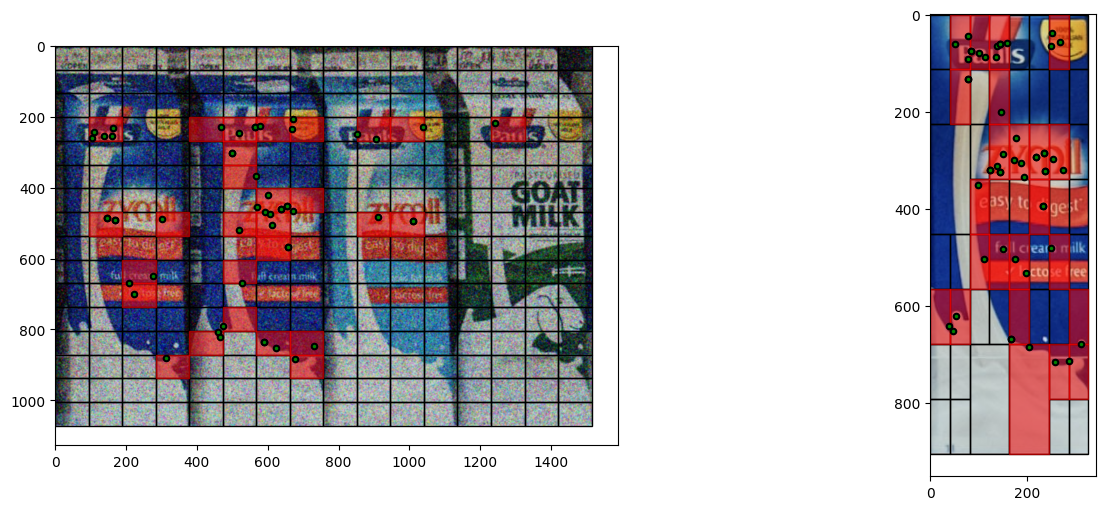

In [76]:
w_template, h_template, _ = template.shape
rects_template = split_rect(
    ( (h_template, w_template), (0, w_template), (0, 0), (h_template, 0) ),
    [ (kp.pt[0], kp.pt[1]) for kp in kp_template ],
    k = 4,
    max_depth = 4
)

w_scene, h_scene, _ = scene.shape
rects_scene = split_rect(
    ( (h_scene, w_scene), (0, w_scene), (0, 0), (h_scene, 0) ),
    [ (kp.pt[0], kp.pt[1]) for kp in kp_scene ],
    k = 4,
    max_depth = 5
)

match_rects_template = getDensity(template_pts, rects_template)
print(f"Confidence on template: {len(match_rects_template) / len(rects_template)}")

match_rects_scene = getDensity(scene_pts, rects_scene)
# print(f"Confidence on scene: {len(match_rects_scene) / len(rects_scene)}")


plt.figure(figsize=(16, 6))

ax = plt.subplot(1, 2, 1)
ax.imshow(scene)
# ax.plot([kp.pt[0] for kp in kp_template], [kp.pt[1] for kp in kp_template], ".")
ax.plot([kp[0] for kp in scene_pts], [kp[1] for kp in scene_pts], "g.", markersize=8, markeredgewidth=1.5, markeredgecolor="black")
for r in rects_scene:
    ax.add_patch(Rectangle(r[2], r[0][0] - r[1][0], r[0][1] - r[3][1], fill=False))
for r in match_rects_scene:
    ax.add_patch(Rectangle(r[2], r[0][0] - r[1][0], r[0][1] - r[3][1], fill=True, alpha=0.5, color="red"))

ax = plt.subplot(1, 2, 2)
ax.imshow(template)
# ax.plot([kp.pt[0] for kp in kp_template], [kp.pt[1] for kp in kp_template], ".")
ax.plot([kp[0] for kp in template_pts], [kp[1] for kp in template_pts], "g.", markersize=8, markeredgewidth=1.5, markeredgecolor="black")
for r in rects_template:
    ax.add_patch(Rectangle(r[2], r[0][0] - r[1][0], r[0][1] - r[3][1], fill=False))
for r in match_rects_template:
    ax.add_patch(Rectangle(r[2], r[0][0] - r[1][0], r[0][1] - r[3][1], fill=True, alpha=0.5, color="red"))

plt.show()

[-1  0  1]


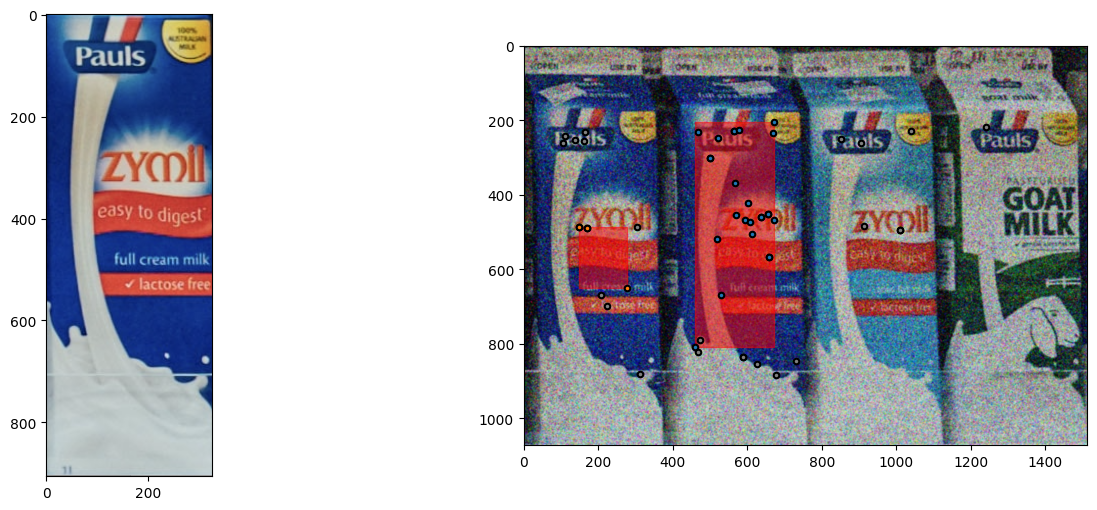

In [77]:
from sklearn.cluster import DBSCAN, OPTICS, HDBSCAN

clusterer = HDBSCAN(
    min_samples = 10,
)

# clusterer = OPTICS(
#     min_samples = 10,
#     metric = "euclidean"
# )

# clusterer = DBSCAN(
#     min_samples = 10,
#     eps = avg_template_match_distance*0.8
# )

clusters = clusterer.fit_predict(scene_pts)
print(np.unique(clusters))


plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(template)

plt.subplot(1, 2, 2)
plt.imshow(scene)
for c in np.unique(clusters):
    points = [ kp for i, kp in enumerate(scene_pts) if clusters[i] == c ]

    color = "gray" if c == -1 else None
    plt.plot([kp[0] for kp in points], [kp[1] for kp in points], ".", markersize=8, markeredgewidth=1.5, markeredgecolor="black", color=color)

    if c != -1:
        x_max = max( [pt[0] for pt in points] )
        x_min = min( [pt[0] for pt in points] )
        y_max = max( [pt[1] for pt in points] )
        y_min = min( [pt[1] for pt in points] )

        plt.gca().add_patch(Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, fill=True, alpha=0.5, color="red"))

plt.show()